In [2]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
from tqdm.auto import tqdm
import cv2
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import umap.umap_ as UMAP
import pims

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading all frames
start = time.time()
all_frames_list = np.load("all_frame_and_action_list.npy")
end = time.time()
print("Training File List containing", len(all_frames_list), "frames loaded in:", end - start)

Training File List containing 8387210 frames loaded in: 1.055616855621338


In [4]:
all_frames_list[0]

'FC-A_08-07-18_preexposurevideo_2018Y_08M_09D_05h_16m_09s_cam_17202346-0000_100832.jpg'

# YOLO v5

In [5]:
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5x", pretrained=True)

Using cache found in /home/anagara8/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-7-5 Python-3.9.10 torch-1.10.1 CUDA:0 (NVIDIA RTX A5000, 24256MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [7]:
image_count = 0
detections_found = 0
total_images = 0

for image in all_frames_list:
    image_count += 1
    if image_count % 100 == 0:
        break
        print("Processed", image_count, "Images..")
    name = image
    if "preexposure" in name:
        append_name = "/media/data_cifs/anagara8/preexposure_action/"
    elif "postcond" in name:
        append_name = "/media/data_cifs/anagara8/postcond_action/"
    elif "postext" in name:
        append_name = "/media/data_cifs/anagara8/postext_action/"
    elif "postret" in name:
        append_name = "/media/data_cifs/anagara8/postret_action/"
    
    image = cv2.imread(append_name + image)
    
    result = yolo_model(image)
    
    if len(result.xyxy[0]) >= 1:
        detections_found += 1
    total_images += 1
    
print("Total Detections:", detections_found, "out of", total_images, "images.")

Total Detections: 53 out of 99 images.


In [12]:
print(yolo_model("/media/data_cifs/anagara8/preexposure_action/"+all_frames_list[1]))

image 1/1: 480x640 1 cat
Speed: 18.4ms pre-process, 31.1ms inference, 1.3ms NMS per image at shape (1, 3, 480, 640)



# Transformer Approach

In [60]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import requests
from torchvision.models import resnet50
import torchvision.transforms as T

In [70]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [71]:
# feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
# model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

# inputs = feature_extractor(images=image, return_tensors="pt")


detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

In [74]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.savefig("test.png")
    
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [85]:
image = Image.open("/media/data_cifs/anagara8/preexposure_action/"+all_frames_list[4])
scores, boxes = detect(image, detr, transform)

In [86]:
plot_results(image, scores, boxes)

# SSD

In [ ]:
PROTOTXT = "MobileNetSSD_deploy.prototxt"
MODEL = "MobileNetSSD_deploy.caffemodel"
INP_VIDEO_PATH = 'cars.mp4'
OUT_VIDEO_PATH = 'cars_detection.mp4'
GPU_SUPPORT = 0
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",  "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [ ]:
net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
if GPU_SUPPORT:
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [ ]:
frame = cv2.imread("/media/data_cifs/anagara8/preexposure_action/"+all_frames_list[2])
plt.imshow(frame)

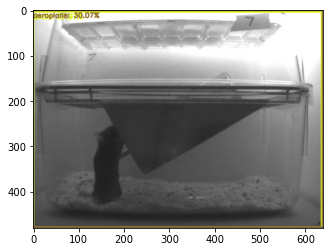

In [27]:
blob = cv2.dnn.blobFromImage(frame, 0.007843, (300, 300), 127.5)
net.setInput(blob)
detections = net.forward()
h, w = frame.shape[:2]
# print("Detections:", detections.shape)
for i in np.arange(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.2:
        idx = int(detections[0, 0, i, 1])
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        label = "{}: {:.2f}%".format(CLASSES[idx],confidence*100)
        cv2.rectangle(frame, (startX, startY), (endX, endY),    COLORS[idx], 2)
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
        plt.imshow(frame)